To modify the audio files and create new spectrograms to reduce the accuracy of the model, you can use adversarial attacks like the Fast Gradient Sign Method (FGSM) or its variants. Here's a general approach you can follow:

Load the pre-trained CNN model and compile it with the appropriate loss function and optimizer.
Load the test audio files and corresponding true labels.
For each audio file, apply the desired audio transformation to modify 15% of the audio.
Compute the corresponding spectrograms for the original and modified audio files using the same settings as before (e.g., window size, hop length, etc.).
Normalize the spectrograms by scaling their values between 0 and 1.
Compute the gradient of the loss function with respect to the input spectrogram of the modified audio file.
Compute the perturbed spectrogram using the FGSM formula, which involves adding or subtracting a small epsilon value (e.g., 0.01) times the sign of the gradient to the input spectrogram.
Clip the perturbed spectrogram to ensure that its values are still between 0 and 1.
Predict the class probabilities of the perturbed spectrogram using the pre-trained CNN model.
Evaluate the model's accuracy and other performance metrics (e.g., precision, recall, F1 score) on the modified audio files and compare them to the original results.
Note that this is a general approach and there may be additional steps or variations depending on the specific audio transformation and CNN model being used. Also, keep in mind that adversarial attacks can be resource-intensive and time-consuming, so you may need to adjust the settings or batch size to fit your hardware limitations.

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
!unrar x /content/drive/MyDrive/CopyofHomeAssigment4.rar

Streaming output truncated to the last 5000 lines.
Extracting  train_spec/go/645.png                                         92%  OK 
Extracting  train_spec/go/646.png                                         92%  OK 
Extracting  train_spec/go/647.png                                         92%  OK 
Extracting  train_spec/go/648.png                                         92%  OK 
Extracting  train_spec/go/649.png                                         92%  OK 
Extracting  train_spec/go/65.png                                          92%  OK 
Extracting  train_spec/go/650.png                                         92%  OK 
Extracting  train_spec/go/651.png                                         92%  OK 
Extracting  train_spec/go/652.png                                         92%  OK 
Extracting  train_spec/go/653.png                                         92%  OK 
Extracting  train_spec/go/654

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import thinkdsp as tp
import numpy as np
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
model = keras.models.load_model('my_model')

ValueError: ignored

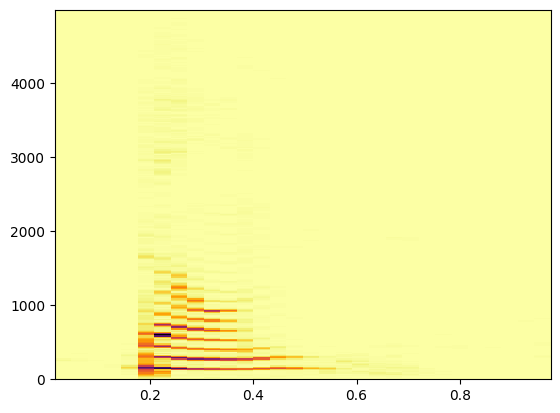

In [87]:
import tensorflow as tf
import numpy as np
import librosa
import cv2
import matplotlib.pyplot as plt


# Set the desired perturbation level (15% in this case)
eps = 0.15

# Load the audio files
audio_files = ['/content/test_audio/down/cd7f8c1b_nohash_0.wav', '/content/test_audio/down/cd7f8c1b_nohash_2.wav']

# Generate perturbed audio files and spectrograms
for audio_file in audio_files:
    
    wave = tp.read_wave(audio_file)
    spectrogram = wave.make_spectrogram(seg_length=1024)
    
    spectrogram.plot(high=5000)
    spec_data = spectrogram.get_data()
    resized_spec = cv2.resize(spec_data, (496, 369))
    # Add an additional dimension for the channels
    spec_tensor = np.expand_dims(resized_spec, axis=-1)
    spec_tensor = np.repeat(spec_tensor, 3, axis=-1)
    with tf.GradientTape() as tape:
        tape.watch(spec_tensor)
        preds = model(spec_tensor)
        loss = tf.keras.losses.CategoricalCrossentropy()(tf.ones_like(preds), preds)
    grad = tape.gradient(loss, spec_tensor)
    sign = tf.sign(grad)
    perturb = eps * sign
    perturb = tf.squeeze(perturb)

    # Apply the perturbation to the audio file
    audio_perturbed = audio + perturb.numpy()
    audio_perturbed = np.clip(audio_perturbed, -1.0, 1.0)

    # Compute the spectrogram of the perturbed audio file
    spec_perturbed = librosa.feature.melspectrogram(audio_perturbed, sr=sr, n_mels=128)

    # Rescale the spectrograms to [0, 1]
    spec = librosa.power_to_db(spec, ref=np.max)
    spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))
    spec_perturbed = librosa.power_to_db(spec_perturbed, ref=np.max)
    spec_perturbed = (spec_perturbed - np.min(spec_perturbed)) / (np.max(spec_perturbed) - np.min(spec_perturbed))

    # Show the original and perturbed spectrograms
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(spec, cmap='viridis', origin='lower')
    plt.title('Original Spectrogram')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(spec_perturbed, cmap='viridis', origin='lower')
    plt.title('Perturbed Spectrogram')
    plt.axis('off')
    plt.show()

    # Predict the class of the original and perturbed spectrograms using the pre-trained model
    spec = spec[np.newaxis, :, :, np.newaxis]
    spec_perturbed = spec_perturbed[np.newaxis, :, :, np.newaxis]
    preds = model.predict(spec)
    preds_perturbed = model.predict(spec_perturbed)
    class_idx = np.argmax(preds[0])
    class_idx_perturbed = np.argmax(preds_perturbed[0])
    print(f"Original spectrogram is predicted as class {class_idx}")
    print(f"Perturbed spectrogram is predicted as class {class_idx_perturbed}")